In [ ]:
# ============================================================================
# 3-PDE STRESS-COUPLED DRUG RELEASE TRACKING WITH PINNs
# ============================================================================
# Advanced Physics-Informed Neural Network for Drug Release Modeling
# Based on the 3-PDE stress-mechanochemical coupling system:
# - u(x,t): Unbound drug concentration
# - v(x,t): Bound drug concentration
# - σ(x,t): Polymer stress
# ============================================================================

# Install necessary packages
!pip install torch torchvision matplotlib numpy scipy tqdm

# Core imports
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
from tqdm import tqdm

print("All packages imported successfully!")
print("=" * 80)
print("3-PDE STRESS-COUPLED DRUG RELEASE PINN")
print("=" * 80)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 878.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 64.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [ ]:
# ============================================================================
# 3-PDE STRESS-COUPLED DRUG RELEASE PHYSICS
# ============================================================================

class StressCoupledDrugReleasePDE:
    """
    Advanced 3-PDE model for stress-coupled drug release:

    PDE 1 (Unbound Drug): ∂u/∂t = D∂²u/∂x² + E∂²σ/∂x² + f(u,v)
    PDE 2 (Bound Drug):   ∂v/∂t = g(u,v)
    PDE 3 (Stress):       ∂σ/∂t + βσ = αu + γ∂u/∂t

    Where:
    - f(u,v) = -g(u,v) = -[u(ub-u) - v(vb-v)]  (binding/unbinding)
    - g(u,v) = u(ub-u) - v(vb-v)                (net binding rate)

    Physical Parameters:
    - D: Drug diffusion coefficient
    - E: Stress-diffusion coupling coefficient (+: enhanced, -: hindered)
    - α, β, γ: Stress equation parameters
    - ub, vb: Maximum binding concentrations
    """

    def __init__(self, diffusion_coeff=0.6, stress_coupling=0.2,
                 alpha=0.2, beta=1.0, gamma=1.0, u_max=1.0, v_max=1.0):
        # Primary transport parameters
        self.D = diffusion_coeff          # Drug diffusion coefficient
        self.E = stress_coupling          # Stress-diffusion coupling

        # Stress equation parameters
        self.alpha = alpha                # Stress generation by unbound drug
        self.beta = beta                  # Stress decay rate
        self.gamma = gamma                # Stress coupling to drug flux

        # Binding parameters
        self.ub = u_max                   # Maximum unbound concentration
        self.vb = v_max                   # Maximum bound concentration

    def binding_kinetics(self, u, v):
        """
        Logistic binding/unbinding kinetics
        - Forward binding: u(ub - u)
        - Reverse unbinding: v(vb - v)
        - Net rate: g(u,v) = forward - reverse
        """
        forward_binding = u * (self.ub - u)      # u → v binding
        reverse_unbinding = v * (self.vb - v)    # v → u unbinding

        g_uv = forward_binding - reverse_unbinding  # Net v formation
        f_uv = -g_uv                                # Net u consumption

        return f_uv, g_uv

    def pde_residual(self, x, t, u, v, sigma):
        """
        Compute residuals for all 3 PDEs using automatic differentiation

        Returns: (pde1_residual, pde2_residual, pde3_residual)
        """
        # Compute temporal derivatives
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u),
                                 create_graph=True)[0]
        v_t = torch.autograd.grad(v, t, grad_outputs=torch.ones_like(v),
                                 create_graph=True)[0]
        sigma_t = torch.autograd.grad(sigma, t, grad_outputs=torch.ones_like(sigma),
                                     create_graph=True)[0]

        # Compute spatial derivatives for u
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u),
                                 create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x),
                                  create_graph=True)[0]

        # Compute spatial derivatives for σ
        sigma_x = torch.autograd.grad(sigma, x, grad_outputs=torch.ones_like(sigma),
                                     create_graph=True)[0]
        sigma_xx = torch.autograd.grad(sigma_x, x, grad_outputs=torch.ones_like(sigma_x),
                                      create_graph=True)[0]

        # Binding/unbinding kinetics
        f_uv, g_uv = self.binding_kinetics(u, v)

        # PDE residuals (should equal zero when satisfied)
        pde1 = u_t - self.D * u_xx - self.E * sigma_xx - f_uv
        pde2 = v_t - g_uv
        pde3 = sigma_t + self.beta * sigma - self.alpha * u - self.gamma * u_t

        return pde1, pde2, pde3

print("3-PDE stress-coupled physics model defined successfully!")


3-PDE stress-coupled physics model defined successfully!


In [ ]:
# ============================================================================
# ENHANCED PINN ARCHITECTURE FOR 3-VARIABLE SYSTEM
# ============================================================================

class StressCoupledPINN(nn.Module):
    """
    Physics-Informed Neural Network for 3-PDE drug release system

    Architecture:
    - Input: (x, t) coordinates
    - Output: (u, v, σ) - unbound drug, bound drug, polymer stress
    - Hidden layers: Fully connected with tanh activation
    """

    def __init__(self, layers, neurons_per_layer, activation='tanh'):
        super(StressCoupledPINN, self).__init__()

        # Build network architecture
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(2, neurons_per_layer))  # Input: (x,t)

        # Hidden layers
        for _ in range(layers - 2):
            self.layers.append(nn.Linear(neurons_per_layer, neurons_per_layer))

        # Output layer: 3 variables (u, v, σ)
        self.layers.append(nn.Linear(neurons_per_layer, 3))

        # Activation function
        if activation == 'tanh':
            self.activation = nn.Tanh()
        elif activation == 'relu':
            self.activation = nn.ReLU()
        elif activation == 'swish':
            self.activation = nn.SiLU()
        else:
            self.activation = nn.Tanh()

        # Initialize weights using Xavier initialization
        self.init_weights()

    def init_weights(self):
        """Initialize network weights for better convergence"""
        for layer in self.layers[:-1]:
            nn.init.xavier_normal_(layer.weight)
            nn.init.zeros_(layer.bias)

        # Final layer with smaller initialization
        nn.init.xavier_normal_(self.layers[-1].weight, gain=0.1)
        nn.init.zeros_(self.layers[-1].bias)

    def forward(self, x, t):
        """
        Forward pass through the network

        Returns: u(x,t), v(x,t), σ(x,t)
        """
        # Concatenate spatial and temporal coordinates
        inputs = torch.cat([x, t], dim=1)

        # Pass through hidden layers
        for layer in self.layers[:-1]:
            inputs = self.activation(layer(inputs))

        # Final layer
        outputs = self.layers[-1](inputs)

        # Split outputs into three variables
        u = outputs[:, 0:1]      # Unbound drug concentration
        v = outputs[:, 1:2]      # Bound drug concentration
        sigma = outputs[:, 2:3]  # Polymer stress

        return u, v, sigma

print("Enhanced PINN architecture for 3-variable system defined successfully!")


Enhanced PINN architecture for 3-variable system defined successfully!


In [ ]:
# ============================================================================
# CONFIGURATION PARAMETERS AND HELPER FUNCTIONS
# ============================================================================

# Enhanced adaptive weighting for 3-PDE system
def get_adaptive_weights_3pde(epoch, pde_losses, initial_losses, boundary_losses):
    """
    Advanced adaptive weighting strategy for 3-PDE system

    Args:
        epoch: Current training epoch
        pde_losses: List of [pde1_loss, pde2_loss, pde3_loss]
        initial_losses: List of [u_init_loss, v_init_loss, sigma_init_loss]
        boundary_losses: List of [u_bound_loss, sigma_bound_loss]

    Returns:
        Tuple of weights: (w_pde1, w_pde2, w_pde3, w_init, w_bound)
    """
    avg_pde_loss = np.mean(pde_losses)
    avg_init_loss = np.mean(initial_losses)
    avg_bound_loss = np.mean(boundary_losses)

    if epoch < 300:
        # Phase 1: Establish constraints first
        return 2.0, 2.0, 2.0, 15.0, 15.0
    elif epoch < 800:
        # Phase 2: Balance physics and constraints
        return 8.0, 8.0, 8.0, 8.0, 8.0
    elif epoch < 1500:
        # Phase 3: Emphasize physics
        return 15.0, 15.0, 15.0, 5.0, 5.0
    else:
        # Phase 4: Fine-tune physics dominance
        return 20.0, 20.0, 20.0, 2.0, 2.0

# Training Configuration
LENGTH = 1.0                          # Spatial domain: [-0.5, 0.5]
TOTAL_TIME = 2.0                      # Time domain: [0, 2]
N_POINTS = 20000                      # Training points (increased for 3 PDEs)
LAYERS = 8                            # Deeper network for complex physics
NEURONS_PER_LAYER = 100              # Wider network
EPOCHS = 3000                        # Longer training for 3-PDE system
LEARNING_RATE = 0.0008               # Slightly lower LR for stability

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def initial_conditions_3pde(x):
    """
    Define initial conditions for 3-variable system at t=0

    u(x,0) = 0.75  (high initial unbound concentration)
    v(x,0) = 0.25  (low initial bound concentration)
    σ(x,0) = 0.0   (no initial stress)
    """
    u_init = torch.full_like(x, 0.75)                    # Unbound drug
    v_init = torch.full_like(x, 0.25)                    # Bound drug
    sigma_init = torch.zeros_like(x)                     # Polymer stress

    return u_init, v_init, sigma_init

def boundary_conditions_3pde(t):
    """
    Define boundary conditions at x = ±0.5

    For u: Third-type (Robin) BCs: D∂u/∂x = k(ua - u)
    For σ: Neumann BCs: ∂σ/∂x = 0 (no stress flux)
    For v: No explicit BC needed (no spatial derivatives)
    """
    # Third-type BC parameters
    k_mass_transfer = 1.0                # Mass transfer coefficient
    u_ambient = 0.0                      # Ambient drug concentration

    return k_mass_transfer, u_ambient

def generate_enhanced_training_data_3pde():
    """
    Generate strategic training points for 3-PDE system

    Returns comprehensive point sets for:
    - Interior PDE residuals
    - Boundary conditions
    - Initial conditions
    """
    # Interior points (main PDE residuals)
    x_interior = (torch.rand(N_POINTS, 1) - 0.5) * LENGTH  # [-0.5, 0.5]
    t_interior = torch.rand(N_POINTS, 1) * TOTAL_TIME      # [0, 2]

    # Add focused sampling near boundaries where BCs matter most
    x_boundary_focus = torch.cat([
        torch.full((N_POINTS//6,), -0.5).reshape(-1, 1),   # Left boundary
        torch.full((N_POINTS//6,), 0.5).reshape(-1, 1),    # Right boundary
    ])
    t_boundary_focus = torch.rand(N_POINTS//3, 1) * TOTAL_TIME

    # Concatenate interior and boundary-focused points
    x_train = torch.cat([x_interior, x_boundary_focus])
    t_train = torch.cat([t_interior, t_boundary_focus])

    # Boundary points for BC enforcement
    x_boundary = torch.cat([
        torch.full((N_POINTS//6,), -0.5).reshape(-1, 1),   # Left boundary
        torch.full((N_POINTS//6,), 0.5).reshape(-1, 1),    # Right boundary
    ])
    t_boundary = torch.rand(N_POINTS//3, 1) * TOTAL_TIME

    # Initial condition points
    x_initial = (torch.rand(N_POINTS//2, 1) - 0.5) * LENGTH
    t_initial = torch.zeros(N_POINTS//2, 1)

    return x_train, t_train, x_boundary, t_boundary, x_initial, t_initial

print("Configuration and helper functions for 3-PDE system defined successfully!")


Using device: cuda
Configuration and helper functions for 3-PDE system defined successfully!


In [ ]:
# ============================================================================
# ENHANCED TRAINING WITH CURRICULUM LEARNING FOR 3-PDE SYSTEM
# ============================================================================

def train_3pde_model():
    """
    Advanced training procedure for 3-PDE stress-coupled drug release system

    Features:
    - Curriculum learning with adaptive weights
    - Gradient clipping for stability
    - L-BFGS fine-tuning
    - Comprehensive loss tracking
    """
    print("Initializing 3-PDE PINN training...")

    # Initialize model and optimizers
    model = StressCoupledPINN(LAYERS, NEURONS_PER_LAYER).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # L-BFGS for precision fine-tuning
    optimizer_lbfgs = torch.optim.LBFGS(
        model.parameters(),
        lr=1.0,
        max_iter=30,
        tolerance_grad=1e-8,
        tolerance_change=1e-10
    )

    # Physics system
    pde_system = StressCoupledDrugReleasePDE()

    # Generate training data
    x_train, t_train, x_boundary, t_boundary, x_initial, t_initial = generate_enhanced_training_data_3pde()

    # Move to device and enable gradients
    x_train = x_train.to(device).requires_grad_(True)
    t_train = t_train.to(device).requires_grad_(True)
    x_boundary = x_boundary.to(device).requires_grad_(True)
    t_boundary = t_boundary.to(device).requires_grad_(True)
    x_initial = x_initial.to(device)
    t_initial = t_initial.to(device)

    # Get boundary condition parameters
    k_transfer, u_ambient = boundary_conditions_3pde(t_boundary)

    # Comprehensive loss tracking
    total_losses = []
    pde1_losses, pde2_losses, pde3_losses = [], [], []
    u_init_losses, v_init_losses, sigma_init_losses = [], [], []
    u_bound_losses, sigma_bound_losses = [], []
    learning_rates = []

    print("Phase 1: Adam optimization with curriculum learning")
    print("-" * 60)

    for epoch in tqdm(range(EPOCHS), desc="Training 3-PDE PINN"):
        optimizer.zero_grad()

        # Forward pass for interior points
        u_pred, v_pred, sigma_pred = model(x_train, t_train)

        # Compute PDE residuals
        pde1_res, pde2_res, pde3_res = pde_system.pde_residual(
            x_train, t_train, u_pred, v_pred, sigma_pred
        )

        loss_pde1 = torch.mean(pde1_res**2)
        loss_pde2 = torch.mean(pde2_res**2)
        loss_pde3 = torch.mean(pde3_res**2)

        # Initial condition losses
        u_init_pred, v_init_pred, sigma_init_pred = model(x_initial, t_initial)
        u_init_true, v_init_true, sigma_init_true = initial_conditions_3pde(x_initial)

        loss_u_init = torch.mean((u_init_pred - u_init_true)**2)
        loss_v_init = torch.mean((v_init_pred - v_init_true)**2)
        loss_sigma_init = torch.mean((sigma_init_pred - sigma_init_true)**2)

        # Boundary condition losses
        u_bound_pred, _, sigma_bound_pred = model(x_boundary, t_boundary)

        # Robin BC for u: D∂u/∂x = k(ua - u)
        u_x_boundary = torch.autograd.grad(
            u_bound_pred, x_boundary,
            grad_outputs=torch.ones_like(u_bound_pred),
            create_graph=True
        )[0]

        # Left boundary: -D∂u/∂x = k(ua - u)
        # Right boundary: D∂u/∂x = k(ua - u)
        left_mask = (x_boundary == -0.5).float()
        right_mask = (x_boundary == 0.5).float()

        bc_residual = (
            left_mask * (-pde_system.D * u_x_boundary - k_transfer * (u_ambient - u_bound_pred)) +
            right_mask * (pde_system.D * u_x_boundary - k_transfer * (u_ambient - u_bound_pred))
        )

        loss_u_boundary = torch.mean(bc_residual**2)

        # Neumann BC for σ: ∂σ/∂x = 0
        sigma_x_boundary = torch.autograd.grad(
            sigma_bound_pred, x_boundary,
            grad_outputs=torch.ones_like(sigma_bound_pred),
            create_graph=True
        )[0]

        loss_sigma_boundary = torch.mean(sigma_x_boundary**2)

        # Adaptive weighting
        pde_losses_current = [loss_pde1.item(), loss_pde2.item(), loss_pde3.item()]
        init_losses_current = [loss_u_init.item(), loss_v_init.item(), loss_sigma_init.item()]
        bound_losses_current = [loss_u_boundary.item(), loss_sigma_boundary.item()]

        w_pde1, w_pde2, w_pde3, w_init, w_bound = get_adaptive_weights_3pde(
            epoch, pde_losses_current, init_losses_current, bound_losses_current
        )

        # Total weighted loss
        total_loss = (
            w_pde1 * loss_pde1 + w_pde2 * loss_pde2 + w_pde3 * loss_pde3 +
            w_init * (loss_u_init + loss_v_init + loss_sigma_init) +
            w_bound * (loss_u_boundary + loss_sigma_boundary)
        )

        # Backpropagation with gradient clipping
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        # Store metrics
        total_losses.append(total_loss.item())
        pde1_losses.append(loss_pde1.item())
        pde2_losses.append(loss_pde2.item())
        pde3_losses.append(loss_pde3.item())
        u_init_losses.append(loss_u_init.item())
        v_init_losses.append(loss_v_init.item())
        sigma_init_losses.append(loss_sigma_init.item())
        u_bound_losses.append(loss_u_boundary.item())
        sigma_bound_losses.append(loss_sigma_boundary.item())
        learning_rates.append(optimizer.param_groups[0]['lr'])

        # Adaptive learning rate
        if epoch > 0 and epoch % 300 == 0:
            avg_pde_loss_recent = np.mean([pde1_losses[-1], pde2_losses[-1], pde3_losses[-1]])
            if epoch >= 300:
                avg_pde_loss_past = np.mean([
                    np.mean(pde1_losses[-300:-250]),
                    np.mean(pde2_losses[-300:-250]),
                    np.mean(pde3_losses[-300:-250])
                ])
                if avg_pde_loss_recent > 0.8 * avg_pde_loss_past:
                    for param_group in optimizer.param_groups:
                        param_group['lr'] *= 0.85
                    print(f"\nEpoch {epoch}: Reduced LR to {optimizer.param_groups[0]['lr']:.6f}")

        # Progress logging
        if epoch % 200 == 0:
            print(f'\nEpoch {epoch:4d}:')
            print(f'  Total Loss: {total_loss.item():.6f}')
            print(f'  PDE Losses: {loss_pde1.item():.6f}, {loss_pde2.item():.6f}, {loss_pde3.item():.6f}')
            print(f'  Init Losses: {loss_u_init.item():.6f}, {loss_v_init.item():.6f}, {loss_sigma_init.item():.6f}')
            print(f'  Bound Losses: {loss_u_boundary.item():.6f}, {loss_sigma_boundary.item():.6f}')
            print(f'  Weights: PDE=({w_pde1:.1f},{w_pde2:.1f},{w_pde3:.1f}), Init={w_init:.1f}, Bound={w_bound:.1f}')


    print("\n3-PDE PINN training completed successfully!")

    return model, (total_losses, pde1_losses, pde2_losses, pde3_losses,
                  u_init_losses, v_init_losses, sigma_init_losses,
                  u_bound_losses, sigma_bound_losses, learning_rates)

print("Enhanced training function for 3-PDE system defined successfully!")


Enhanced training function for 3-PDE system defined successfully!


In [ ]:
# ============================================================================
# COMPREHENSIVE VISUALIZATION SUITE FOR 3-PDE SYSTEM
# ============================================================================

def plot_training_progress_3pde(loss_data):
    """
    Comprehensive training progress visualization for 3-PDE system
    """
    (total_losses, pde1_losses, pde2_losses, pde3_losses,
     u_init_losses, v_init_losses, sigma_init_losses,
     u_bound_losses, sigma_bound_losses, learning_rates) = loss_data

    fig, axes = plt.subplots(3, 3, figsize=(20, 15))

    # PDE losses
    axes[0,0].semilogy(pde1_losses, 'b-', linewidth=2, label='PDE 1: Unbound Drug')
    axes[0,0].set_title('PDE 1 Loss (Unbound Drug Transport)')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].grid(True)

    axes[0,1].semilogy(pde2_losses, 'r-', linewidth=2, label='PDE 2: Bound Drug')
    axes[0,1].set_title('PDE 2 Loss (Binding Kinetics)')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Loss')
    axes[0,1].grid(True)

    axes[0,2].semilogy(pde3_losses, 'g-', linewidth=2, label='PDE 3: Stress')
    axes[0,2].set_title('PDE 3 Loss (Polymer Stress)')
    axes[0,2].set_xlabel('Epoch')
    axes[0,2].set_ylabel('Loss')
    axes[0,2].grid(True)

    # Initial condition losses
    axes[1,0].semilogy(u_init_losses, 'cyan', linewidth=2)
    axes[1,0].set_title('Initial Condition: Unbound Drug')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('Loss')
    axes[1,0].grid(True)

    axes[1,1].semilogy(v_init_losses, 'magenta', linewidth=2)
    axes[1,1].set_title('Initial Condition: Bound Drug')
    axes[1,1].set_xlabel('Epoch')
    axes[1,1].set_ylabel('Loss')
    axes[1,1].grid(True)

    axes[1,2].semilogy(sigma_init_losses, 'orange', linewidth=2)
    axes[1,2].set_title('Initial Condition: Stress')
    axes[1,2].set_xlabel('Epoch')
    axes[1,2].set_ylabel('Loss')
    axes[1,2].grid(True)

    # Combined analyses
    axes[2,0].semilogy(total_losses, 'black', linewidth=3)
    axes[2,0].set_title('Total Weighted Loss')
    axes[2,0].set_xlabel('Epoch')
    axes[2,0].set_ylabel('Loss')
    axes[2,0].grid(True)

    axes[2,1].plot(learning_rates, 'purple', linewidth=2)
    axes[2,1].set_title('Learning Rate Schedule')
    axes[2,1].set_xlabel('Epoch')
    axes[2,1].set_ylabel('Learning Rate')
    axes[2,1].grid(True)

    # Physics vs constraints balance
    if len(pde1_losses) > 100:
        physics_loss = np.array(pde1_losses) + np.array(pde2_losses) + np.array(pde3_losses)
        constraint_loss = (np.array(u_init_losses) + np.array(v_init_losses) +
                          np.array(sigma_init_losses) + np.array(u_bound_losses) +
                          np.array(sigma_bound_losses))
        balance_ratio = physics_loss / (constraint_loss + 1e-10)

        axes[2,2].plot(balance_ratio, 'brown', linewidth=2)
        axes[2,2].set_title('Physics/Constraints Balance')
        axes[2,2].set_xlabel('Epoch')
        axes[2,2].set_ylabel('Ratio')
        axes[2,2].grid(True)

    plt.tight_layout()
    plt.show()

def plot_solution_evolution_3pde(model):
    """
    Visualize evolution of all 3 variables over space and time
    """
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))

    x_test = torch.linspace(-0.5, 0.5, 100).reshape(-1, 1).to(device)
    times = [0, 0.5, 1.0, 1.5, 2.0]
    colors = plt.cm.viridis(np.linspace(0, 1, len(times)))

    # Spatial profiles over time
    for i, t_val in enumerate(times):
        t_test = torch.full_like(x_test, t_val).to(device)

        with torch.no_grad():
            u_pred, v_pred, sigma_pred = model(x_test, t_test)

        x_np = x_test.cpu().numpy()
        u_np = u_pred.cpu().numpy()
        v_np = v_pred.cpu().numpy()
        sigma_np = sigma_pred.cpu().numpy()

        # Unbound drug profiles
        axes[0,0].plot(x_np, u_np, linewidth=2, color=colors[i], label=f't = {t_val}')

        # Bound drug profiles
        axes[0,1].plot(x_np, v_np, linewidth=2, color=colors[i], label=f't = {t_val}')

        # Stress profiles
        axes[0,2].plot(x_np, sigma_np, linewidth=2, color=colors[i], label=f't = {t_val}')

    axes[0,0].set_title('Unbound Drug Concentration u(x,t)')
    axes[0,0].set_xlabel('Position x')
    axes[0,0].set_ylabel('Concentration')
    axes[0,0].legend()
    axes[0,0].grid(True)

    axes[0,1].set_title('Bound Drug Concentration v(x,t)')
    axes[0,1].set_xlabel('Position x')
    axes[0,1].set_ylabel('Concentration')
    axes[0,1].legend()
    axes[0,1].grid(True)

    axes[0,2].set_title('Polymer Stress σ(x,t)')
    axes[0,2].set_xlabel('Position x')
    axes[0,2].set_ylabel('Stress')
    axes[0,2].legend()
    axes[0,2].grid(True)

    # 2D heatmaps
    x_grid = torch.linspace(-0.5, 0.5, 60).reshape(-1, 1)
    t_grid = torch.linspace(0, TOTAL_TIME, 60).reshape(-1, 1)
    X_grid, T_grid = torch.meshgrid(x_grid.squeeze(), t_grid.squeeze(), indexing='ij')

    X_flat = X_grid.reshape(-1, 1).to(device)
    T_flat = T_grid.reshape(-1, 1).to(device)

    with torch.no_grad():
        U_pred, V_pred, Sigma_pred = model(X_flat, T_flat)

    U_2d = U_pred.cpu().numpy().reshape(X_grid.shape)
    V_2d = V_pred.cpu().numpy().reshape(X_grid.shape)
    Sigma_2d = Sigma_pred.cpu().numpy().reshape(X_grid.shape)

    # Unbound drug heatmap
    im1 = axes[1,0].imshow(U_2d, extent=[0, TOTAL_TIME, -0.5, 0.5],
                          aspect='auto', origin='lower', cmap='viridis')
    axes[1,0].set_title('Unbound Drug Heatmap')
    axes[1,0].set_xlabel('Time')
    axes[1,0].set_ylabel('Position')
    plt.colorbar(im1, ax=axes[1,0])

    # Bound drug heatmap
    im2 = axes[1,1].imshow(V_2d, extent=[0, TOTAL_TIME, -0.5, 0.5],
                          aspect='auto', origin='lower', cmap='plasma')
    axes[1,1].set_title('Bound Drug Heatmap')
    axes[1,1].set_xlabel('Time')
    axes[1,1].set_ylabel('Position')
    plt.colorbar(im2, ax=axes[1,1])

    # Stress heatmap
    im3 = axes[1,2].imshow(Sigma_2d, extent=[0, TOTAL_TIME, -0.5, 0.5],
                          aspect='auto', origin='lower', cmap='coolwarm')
    axes[1,2].set_title('Polymer Stress Heatmap')
    axes[1,2].set_xlabel('Time')
    axes[1,2].set_ylabel('Position')
    plt.colorbar(im3, ax=axes[1,2])

    # Temporal evolution at center (x=0)
    t_evolution = torch.linspace(0, TOTAL_TIME, 100).reshape(-1, 1).to(device)
    x_center = torch.zeros_like(t_evolution).to(device)

    with torch.no_grad():
        u_center, v_center, sigma_center = model(x_center, t_evolution)

    t_np = t_evolution.cpu().numpy()

    axes[2,0].plot(t_np, u_center.cpu().numpy(), 'b-', linewidth=3)
    axes[2,0].set_title('Unbound Drug at Center (x=0)')
    axes[2,0].set_xlabel('Time')
    axes[2,0].set_ylabel('Concentration')
    axes[2,0].grid(True)

    axes[2,1].plot(t_np, v_center.cpu().numpy(), 'r-', linewidth=3)
    axes[2,1].set_title('Bound Drug at Center (x=0)')
    axes[2,1].set_xlabel('Time')
    axes[2,1].set_ylabel('Concentration')
    axes[2,1].grid(True)

    axes[2,2].plot(t_np, sigma_center.cpu().numpy(), 'g-', linewidth=3)
    axes[2,2].set_title('Stress at Center (x=0)')
    axes[2,2].set_xlabel('Time')
    axes[2,2].set_ylabel('Stress')
    axes[2,2].grid(True)

    plt.tight_layout()
    plt.show()

def plot_binding_dynamics_analysis(model):
    """
    Analyze and visualize drug binding/unbinding dynamics
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Create analysis grid
    x_analysis = torch.linspace(-0.5, 0.5, 50).reshape(-1, 1).to(device)
    t_analysis = torch.linspace(0, TOTAL_TIME, 50).reshape(-1, 1).to(device)

    # Binding rate analysis over time at center
    x_center = torch.zeros(50, 1).to(device)

    with torch.no_grad():
        u_center, v_center, _ = model(x_center, t_analysis)

    # Compute binding rates using model parameters
    pde_system = StressCoupledDrugReleasePDE()
    forward_binding = u_center * (pde_system.ub - u_center)
    reverse_unbinding = v_center * (pde_system.vb - v_center)
    net_binding = forward_binding - reverse_unbinding

    t_np = t_analysis.cpu().numpy()

    axes[0,0].plot(t_np, forward_binding.cpu().numpy(), 'b-', label='Forward (u→v)', linewidth=2)
    axes[0,0].plot(t_np, reverse_unbinding.cpu().numpy(), 'r-', label='Reverse (v→u)', linewidth=2)
    axes[0,0].plot(t_np, net_binding.cpu().numpy(), 'g-', label='Net Binding', linewidth=2)
    axes[0,0].set_title('Binding Kinetics at Center')
    axes[0,0].set_xlabel('Time')
    axes[0,0].set_ylabel('Binding Rate')
    axes[0,0].legend()
    axes[0,0].grid(True)

    # Total drug distribution over time
    total_unbound = []
    total_bound = []
    times_eval = np.linspace(0, TOTAL_TIME, 20)

    for t_val in times_eval:
        t_full = torch.full_like(x_analysis, t_val).to(device)

        with torch.no_grad():
            u_pred, v_pred, _ = model(x_analysis, t_full)

        total_u = torch.trapz(u_pred.squeeze(), x_analysis.squeeze()).item()
        total_v = torch.trapz(v_pred.squeeze(), x_analysis.squeeze()).item()

        total_unbound.append(total_u)
        total_bound.append(total_v)

    axes[0,1].plot(times_eval, total_unbound, 'b-', linewidth=3, label='Total Unbound')
    axes[0,1].plot(times_eval, total_bound, 'r-', linewidth=3, label='Total Bound')
    axes[0,1].plot(times_eval, np.array(total_unbound) + np.array(total_bound),
                  'k--', linewidth=2, label='Total Drug')
    axes[0,1].set_title('Drug Distribution Over Time')
    axes[0,1].set_xlabel('Time')
    axes[0,1].set_ylabel('Total Amount')
    axes[0,1].legend()
    axes[0,1].grid(True)

    # Stress effects on transport
    t_stress = torch.full_like(x_analysis, 1.0).to(device)  # Mid-time analysis

    with torch.no_grad():
        u_stress, v_stress, sigma_stress = model(x_analysis, t_stress)

    x_np = x_analysis.cpu().numpy()

    axes[1,0].plot(x_np, u_stress.cpu().numpy(), 'b-', linewidth=2, label='Unbound Drug')
    axes[1,0].plot(x_np, sigma_stress.cpu().numpy(), 'g-', linewidth=2, label='Stress')
    axes[1,0].set_title('Drug-Stress Coupling (t=1.0)')
    axes[1,0].set_xlabel('Position')
    axes[1,0].set_ylabel('Concentration/Stress')
    axes[1,0].legend()
    axes[1,0].grid(True)

    # Drug release rate analysis
    release_rate = np.gradient(total_unbound, times_eval)

    axes[1,1].plot(times_eval, release_rate, 'purple', linewidth=3)
    axes[1,1].set_title('Drug Release Rate')
    axes[1,1].set_xlabel('Time')
    axes[1,1].set_ylabel('Release Rate')
    axes[1,1].grid(True)

    plt.tight_layout()
    plt.show()

def create_3d_visualization_3pde(model):
    """
    Create stunning 3D visualizations for all three variables
    """
    fig = plt.figure(figsize=(24, 8))

    # Prepare 3D data
    x_3d = torch.linspace(-0.5, 0.5, 40)
    t_3d = torch.linspace(0, TOTAL_TIME, 40)
    X_3d, T_3d = torch.meshgrid(x_3d, t_3d, indexing='ij')

    X_flat = X_3d.reshape(-1, 1).to(device)
    T_flat = T_3d.reshape(-1, 1).to(device)

    with torch.no_grad():
        U_pred, V_pred, Sigma_pred = model(X_flat, T_flat)

    U_3d = U_pred.cpu().numpy().reshape(X_3d.shape)
    V_3d = V_pred.cpu().numpy().reshape(X_3d.shape)
    Sigma_3d = Sigma_pred.cpu().numpy().reshape(X_3d.shape)

    # Unbound drug 3D surface
    ax1 = fig.add_subplot(131, projection='3d')
    surf1 = ax1.plot_surface(T_3d.numpy(), X_3d.numpy(), U_3d,
                            cmap='viridis', alpha=0.9, linewidth=0)
    ax1.set_xlabel('Time', fontsize=12)
    ax1.set_ylabel('Position', fontsize=12)
    ax1.set_zlabel('Unbound Drug u(x,t)', fontsize=12)
    ax1.set_title('3D Unbound Drug Distribution', fontsize=14, fontweight='bold')

    # Bound drug 3D surface
    ax2 = fig.add_subplot(132, projection='3d')
    surf2 = ax2.plot_surface(T_3d.numpy(), X_3d.numpy(), V_3d,
                            cmap='plasma', alpha=0.9, linewidth=0)
    ax2.set_xlabel('Time', fontsize=12)
    ax2.set_ylabel('Position', fontsize=12)
    ax2.set_zlabel('Bound Drug v(x,t)', fontsize=12)
    ax2.set_title('3D Bound Drug Distribution', fontsize=14, fontweight='bold')

    # Stress 3D surface
    ax3 = fig.add_subplot(133, projection='3d')
    surf3 = ax3.plot_surface(T_3d.numpy(), X_3d.numpy(), Sigma_3d,
                            cmap='coolwarm', alpha=0.9, linewidth=0)
    ax3.set_xlabel('Time', fontsize=12)
    ax3.set_ylabel('Position', fontsize=12)
    ax3.set_zlabel('Stress σ(x,t)', fontsize=12)
    ax3.set_title('3D Polymer Stress Distribution', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

print("Comprehensive visualization suite for 3-PDE system defined successfully!")


Comprehensive visualization suite for 3-PDE system defined successfully!


In [ ]:
# ============================================================================
# FIXED PLOTTING FUNCTIONS - PROPERLY SAVES IMAGES
# ============================================================================

def plot_training_progress_3pde_FIXED(loss_data, save_path=None):
    """Fixed training progress visualization that properly saves images"""

    # Unpack loss data
    (total_losses, pde1_losses, pde2_losses, pde3_losses,
     u_init_losses, v_init_losses, sigma_init_losses,
     u_bound_losses, sigma_bound_losses, learning_rates) = loss_data

    # Create figure with explicit size
    fig, axes = plt.subplots(3, 3, figsize=(20, 15))

    # PDE losses
    axes[0,0].semilogy(pde1_losses, 'b-', linewidth=2, label='PDE 1: Unbound Drug')
    axes[0,0].set_title('PDE 1 Loss (Unbound Drug Transport)', fontsize=12, fontweight='bold')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Loss')
    axes[0,0].grid(True)
    axes[0,0].legend()

    axes[0,1].semilogy(pde2_losses, 'r-', linewidth=2, label='PDE 2: Bound Drug')
    axes[0,1].set_title('PDE 2 Loss (Binding Kinetics)', fontsize=12, fontweight='bold')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Loss')
    axes[0,1].grid(True)
    axes[0,1].legend()

    axes[0,2].semilogy(pde3_losses, 'g-', linewidth=2, label='PDE 3: Stress')
    axes[0,2].set_title('PDE 3 Loss (Polymer Stress)', fontsize=12, fontweight='bold')
    axes[0,2].set_xlabel('Epoch')
    axes[0,2].set_ylabel('Loss')
    axes[0,2].grid(True)
    axes[0,2].legend()

    # Initial condition losses
    axes[1,0].semilogy(u_init_losses, 'cyan', linewidth=2)
    axes[1,0].set_title('Initial Condition: Unbound Drug', fontsize=12, fontweight='bold')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('Loss')
    axes[1,0].grid(True)

    axes[1,1].semilogy(v_init_losses, 'magenta', linewidth=2)
    axes[1,1].set_title('Initial Condition: Bound Drug', fontsize=12, fontweight='bold')
    axes[1,1].set_xlabel('Epoch')
    axes[1,1].set_ylabel('Loss')
    axes[1,1].grid(True)

    axes[1,2].semilogy(sigma_init_losses, 'orange', linewidth=2)
    axes[1,2].set_title('Initial Condition: Stress', fontsize=12, fontweight='bold')
    axes[1,2].set_xlabel('Epoch')
    axes[1,2].set_ylabel('Loss')
    axes[1,2].grid(True)

    # Combined analyses
    axes[2,0].semilogy(total_losses, 'black', linewidth=3)
    axes[2,0].set_title('Total Weighted Loss', fontsize=12, fontweight='bold')
    axes[2,0].set_xlabel('Epoch')
    axes[2,0].set_ylabel('Loss')
    axes[2,0].grid(True)

    axes[2,1].plot(learning_rates, 'purple', linewidth=2)
    axes[2,1].set_title('Learning Rate Schedule', fontsize=12, fontweight='bold')
    axes[2,1].set_xlabel('Epoch')
    axes[2,1].set_ylabel('Learning Rate')
    axes[2,1].grid(True)

    # Physics vs constraints balance
    if len(pde1_losses) > 100:
        physics_loss = np.array(pde1_losses) + np.array(pde2_losses) + np.array(pde3_losses)
        constraint_loss = (np.array(u_init_losses) + np.array(v_init_losses) +
                          np.array(sigma_init_losses) + np.array(u_bound_losses) +
                          np.array(sigma_bound_losses))
        balance_ratio = physics_loss / (constraint_loss + 1e-10)

        axes[2,2].plot(balance_ratio, 'brown', linewidth=2)
        axes[2,2].set_title('Physics/Constraints Balance', fontsize=12, fontweight='bold')
        axes[2,2].set_xlabel('Epoch')
        axes[2,2].set_ylabel('Ratio')
        axes[2,2].grid(True)

    plt.tight_layout()

    # Save BEFORE show
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        fig.savefig(save_path.replace('.png', '.pdf'), bbox_inches='tight')
        print(f"✅ Training progress saved: {save_path}")

    plt.show()
    plt.close(fig)
    return fig

def analyze_3pde_compliance_FIXED(model, pde_system, save_path=None):
    """Fixed PDE compliance analysis that properly saves images"""

    print("Analyzing 3-PDE compliance across domain...")

    # Create analysis grid
    x_test = torch.linspace(-0.5, 0.5, 60).reshape(-1, 1).to(device)
    t_test = torch.linspace(0, TOTAL_TIME, 60).reshape(-1, 1).to(device)

    X_grid, T_grid = torch.meshgrid(x_test.squeeze(), t_test.squeeze(), indexing='ij')
    X_flat = X_grid.reshape(-1, 1).to(device).requires_grad_(True)
    T_flat = T_grid.reshape(-1, 1).to(device).requires_grad_(True)

    # Compute predictions and residuals
    u_pred, v_pred, sigma_pred = model(X_flat, T_flat)
    pde1_res, pde2_res, pde3_res = pde_system.pde_residual(X_flat, T_flat, u_pred, v_pred, sigma_pred)

    # Calculate residual magnitudes
    pde1_mag = torch.abs(pde1_res).detach().cpu().numpy().reshape(X_grid.shape)
    pde2_mag = torch.abs(pde2_res).detach().cpu().numpy().reshape(X_grid.shape)
    pde3_mag = torch.abs(pde3_res).detach().cpu().numpy().reshape(X_grid.shape)

    # Create diagnostic plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # PDE residual heatmaps
    titles = ['PDE 1: Unbound Drug', 'PDE 2: Bound Drug', 'PDE 3: Polymer Stress']
    residuals = [pde1_mag, pde2_mag, pde3_mag]

    for i, (ax, title, residual) in enumerate(zip(axes[0], titles, residuals)):
        im = ax.imshow(residual, extent=[0, TOTAL_TIME, -0.5, 0.5],
                      aspect='auto', origin='lower', cmap='hot')
        ax.set_title(f'{title} Residuals', fontsize=12, fontweight='bold')
        ax.set_xlabel('Time')
        ax.set_ylabel('Position')
        plt.colorbar(im, ax=ax)

    # Residual statistics plots
    axes[1,0].plot(np.linspace(0, TOTAL_TIME, 60), np.mean(pde1_mag, axis=0), 'b-', linewidth=2)
    axes[1,0].set_title('PDE 1 Temporal Average', fontsize=12, fontweight='bold')
    axes[1,0].set_xlabel('Time')
    axes[1,0].set_ylabel('Average Residual')
    axes[1,0].grid(True)

    axes[1,1].plot(np.linspace(0, TOTAL_TIME, 60), np.mean(pde2_mag, axis=0), 'r-', linewidth=2)
    axes[1,1].set_title('PDE 2 Temporal Average', fontsize=12, fontweight='bold')
    axes[1,1].set_xlabel('Time')
    axes[1,1].set_ylabel('Average Residual')
    axes[1,1].grid(True)

    axes[1,2].plot(np.linspace(0, TOTAL_TIME, 60), np.mean(pde3_mag, axis=0), 'g-', linewidth=2)
    axes[1,2].set_title('PDE 3 Temporal Average', fontsize=12, fontweight='bold')
    axes[1,2].set_xlabel('Time')
    axes[1,2].set_ylabel('Average Residual')
    axes[1,2].grid(True)

    plt.tight_layout()

    # Save BEFORE show
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        fig.savefig(save_path.replace('.png', '.pdf'), bbox_inches='tight')
        print(f"✅ PDE compliance saved: {save_path}")

    plt.show()
    plt.close(fig)

    # Print statistics
    print(f"\nPDE Compliance Statistics:")
    print(f"  PDE 1 (Unbound): Max={np.max(pde1_mag):.6f}, Mean={np.mean(pde1_mag):.6f}")
    print(f"  PDE 2 (Bound):   Max={np.max(pde2_mag):.6f}, Mean={np.mean(pde2_mag):.6f}")
    print(f"  PDE 3 (Stress):  Max={np.max(pde3_mag):.6f}, Mean={np.mean(pde3_mag):.6f}")

    return pde1_mag, pde2_mag, pde3_mag

def plot_solution_evolution_3pde_FIXED(model, save_path=None):
    """Fixed solution evolution visualization"""

    fig, axes = plt.subplots(3, 3, figsize=(20, 15))

    x_test = torch.linspace(-0.5, 0.5, 100).reshape(-1, 1).to(device)
    times = [0, 0.5, 1.0, 1.5, 2.0]
    colors = plt.cm.viridis(np.linspace(0, 1, len(times)))

    # Spatial profiles over time
    for i, t_val in enumerate(times):
        t_test = torch.full_like(x_test, t_val).to(device)

        with torch.no_grad():
            u_pred, v_pred, sigma_pred = model(x_test, t_test)

        x_np = x_test.cpu().numpy()
        u_np = u_pred.cpu().numpy()
        v_np = v_pred.cpu().numpy()
        sigma_np = sigma_pred.cpu().numpy()

        # Unbound drug profiles
        axes[0,0].plot(x_np, u_np, linewidth=2, color=colors[i], label=f't = {t_val}')
        axes[0,1].plot(x_np, v_np, linewidth=2, color=colors[i], label=f't = {t_val}')
        axes[0,2].plot(x_np, sigma_np, linewidth=2, color=colors[i], label=f't = {t_val}')

    axes[0,0].set_title('Unbound Drug Concentration u(x,t)', fontsize=12, fontweight='bold')
    axes[0,0].set_xlabel('Position x')
    axes[0,0].set_ylabel('Concentration')
    axes[0,0].legend()
    axes[0,0].grid(True)

    axes[0,1].set_title('Bound Drug Concentration v(x,t)', fontsize=12, fontweight='bold')
    axes[0,1].set_xlabel('Position x')
    axes[0,1].set_ylabel('Concentration')
    axes[0,1].legend()
    axes[0,1].grid(True)

    axes[0,2].set_title('Polymer Stress σ(x,t)', fontsize=12, fontweight='bold')
    axes[0,2].set_xlabel('Position x')
    axes[0,2].set_ylabel('Stress')
    axes[0,2].legend()
    axes[0,2].grid(True)

    # 2D heatmaps
    x_grid = torch.linspace(-0.5, 0.5, 60).reshape(-1, 1)
    t_grid = torch.linspace(0, TOTAL_TIME, 60).reshape(-1, 1)
    X_grid, T_grid = torch.meshgrid(x_grid.squeeze(), t_grid.squeeze(), indexing='ij')

    X_flat = X_grid.reshape(-1, 1).to(device)
    T_flat = T_grid.reshape(-1, 1).to(device)

    with torch.no_grad():
        U_pred, V_pred, Sigma_pred = model(X_flat, T_flat)

    U_2d = U_pred.cpu().numpy().reshape(X_grid.shape)
    V_2d = V_pred.cpu().numpy().reshape(X_grid.shape)
    Sigma_2d = Sigma_pred.cpu().numpy().reshape(X_grid.shape)

    # Heatmaps
    im1 = axes[1,0].imshow(U_2d, extent=[0, TOTAL_TIME, -0.5, 0.5],
                          aspect='auto', origin='lower', cmap='viridis')
    axes[1,0].set_title('Unbound Drug Heatmap', fontsize=12, fontweight='bold')
    axes[1,0].set_xlabel('Time')
    axes[1,0].set_ylabel('Position')
    plt.colorbar(im1, ax=axes[1,0])

    im2 = axes[1,1].imshow(V_2d, extent=[0, TOTAL_TIME, -0.5, 0.5],
                          aspect='auto', origin='lower', cmap='plasma')
    axes[1,1].set_title('Bound Drug Heatmap', fontsize=12, fontweight='bold')
    axes[1,1].set_xlabel('Time')
    axes[1,1].set_ylabel('Position')
    plt.colorbar(im2, ax=axes[1,1])

    im3 = axes[1,2].imshow(Sigma_2d, extent=[0, TOTAL_TIME, -0.5, 0.5],
                          aspect='auto', origin='lower', cmap='coolwarm')
    axes[1,2].set_title('Polymer Stress Heatmap', fontsize=12, fontweight='bold')
    axes[1,2].set_xlabel('Time')
    axes[1,2].set_ylabel('Position')
    plt.colorbar(im3, ax=axes[1,2])

    # Temporal evolution at center
    t_evolution = torch.linspace(0, TOTAL_TIME, 100).reshape(-1, 1).to(device)
    x_center = torch.zeros_like(t_evolution).to(device)

    with torch.no_grad():
        u_center, v_center, sigma_center = model(x_center, t_evolution)

    t_np = t_evolution.cpu().numpy()

    axes[2,0].plot(t_np, u_center.cpu().numpy(), 'b-', linewidth=3)
    axes[2,0].set_title('Unbound Drug at Center (x=0)', fontsize=12, fontweight='bold')
    axes[2,0].set_xlabel('Time')
    axes[2,0].set_ylabel('Concentration')
    axes[2,0].grid(True)

    axes[2,1].plot(t_np, v_center.cpu().numpy(), 'r-', linewidth=3)
    axes[2,1].set_title('Bound Drug at Center (x=0)', fontsize=12, fontweight='bold')
    axes[2,1].set_xlabel('Time')
    axes[2,1].set_ylabel('Concentration')
    axes[2,1].grid(True)

    axes[2,2].plot(t_np, sigma_center.cpu().numpy(), 'g-', linewidth=3)
    axes[2,2].set_title('Stress at Center (x=0)', fontsize=12, fontweight='bold')
    axes[2,2].set_xlabel('Time')
    axes[2,2].set_ylabel('Stress')
    axes[2,2].grid(True)

    plt.tight_layout()

    # Save BEFORE show
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        fig.savefig(save_path.replace('.png', '.pdf'), bbox_inches='tight')
        print(f"✅ Solution evolution saved: {save_path}")

    plt.show()
    plt.close(fig)
    return fig

def analyze_mass_conservation_3pde(model):
    """Analyze mass conservation and binding dynamics"""
    print("Analyzing mass conservation and binding dynamics...")

    x_test = torch.linspace(-0.5, 0.5, 100).reshape(-1, 1).to(device)

    mass_metrics = {
        'time': [],
        'total_unbound': [],
        'total_bound': [],
        'total_drug': [],
        'binding_rate': [],
        'stress_magnitude': []
    }

    for t_val in [0, 0.5, 1.0, 1.5, 2.0]:
        t_current = torch.full_like(x_test, t_val).to(device)

        with torch.no_grad():
            u_pred, v_pred, sigma_pred = model(x_test, t_current)

        # Integrate over space
        total_u = torch.trapz(u_pred.squeeze(), x_test.squeeze()).item()
        total_v = torch.trapz(v_pred.squeeze(), x_test.squeeze()).item()
        total_drug = total_u + total_v
        avg_stress = torch.mean(torch.abs(sigma_pred)).item()

        # Estimate binding rate
        if t_val > 0:
            prev_v = mass_metrics['total_bound'][-1] if mass_metrics['total_bound'] else total_v
            binding_rate = (total_v - prev_v) / 0.5
        else:
            binding_rate = 0.0

        mass_metrics['time'].append(t_val)
        mass_metrics['total_unbound'].append(total_u)
        mass_metrics['total_bound'].append(total_v)
        mass_metrics['total_drug'].append(total_drug)
        mass_metrics['binding_rate'].append(binding_rate)
        mass_metrics['stress_magnitude'].append(avg_stress)

        print(f"  t={t_val:4.1f}: Unbound={total_u:.4f}, Bound={total_v:.4f}, "
              f"Total={total_drug:.4f}, Stress={avg_stress:.4f}")

    # Mass conservation analysis
    initial_total = mass_metrics['total_drug'][0]
    conservation_errors = [abs(total - initial_total)/initial_total * 100
                          for total in mass_metrics['total_drug']]

    print(f"\nMass Conservation Analysis:")
    for i, (t, error) in enumerate(zip(mass_metrics['time'], conservation_errors)):
        print(f"  t={t:4.1f}: Conservation error = {error:.3f}%")

    return mass_metrics

print("Fixed plotting and analysis functions defined successfully!")


✅ Fixed plotting and analysis functions defined successfully!


In [ ]:
# ============================================================================
# BULLETPROOF SAVING FUNCTION WITH MULTIPLE SAFEGUARDS
# ============================================================================
import os
import json
import torch
import pandas as pd
import shutil
import time
from datetime import datetime

def save_complete_results_BULLETPROOF(trained_model, loss_data, save_dir="./training_results/"):
    """
    Bulletproof saving function with multiple safeguards for Google Drive
    """
    print(" Starting bulletproof file saving process...")

    # Create local save directory
    os.makedirs(save_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    saved_files = []

    # ============================================================================
    # STEP 1: MOUNT AND VERIFY GOOGLE DRIVE
    # ============================================================================
    print("1. Mounting and verifying Google Drive...")
    try:
        from google.colab import drive
        drive.mount('/content/drive', force_remount=True)  # Force remount

        # Create and verify Drive directory
        drive_dir = "/content/drive/MyDrive/3PDE_Complete_Results/"
        os.makedirs(drive_dir, exist_ok=True)

        # Test write access
        test_file = os.path.join(drive_dir, "test_write.txt")
        with open(test_file, 'w') as f:
            f.write("test")

        if os.path.exists(test_file):
            os.remove(test_file)
            print(" Google Drive mounted and write access confirmed")
        else:
            raise Exception("Cannot write to Google Drive")

    except Exception as e:
        print(f" Google Drive setup failed: {e}")
        print(" Will save to local directory only")
        drive_dir = None

    # ============================================================================
    # STEP 2: SAVE DIRECTLY TO GOOGLE DRIVE (NOT LOCAL FIRST)
    # ============================================================================
    if drive_dir:
        print("2. Saving files directly to Google Drive...")
        final_save_dir = drive_dir
    else:
        print("2. Saving files to local directory...")
        final_save_dir = save_dir

    # ============================================================================
    # STEP 3: GENERATE AND SAVE PLOTS WITH VERIFICATION
    # ============================================================================

    def save_plot_with_verification(plot_function, filename_base, *args, **kwargs):
        """Save plot with multiple verification steps"""
        plot_path = os.path.join(final_save_dir, f"{filename_base}_{timestamp}.png")
        pdf_path = os.path.join(final_save_dir, f"{filename_base}_{timestamp}.pdf")

        try:
            # Generate and save plot
            plot_function(*args, save_path=plot_path, **kwargs)

            # Verify files exist and have content
            if os.path.exists(plot_path) and os.path.getsize(plot_path) > 1000:  # > 1KB
                print(f" {filename_base} saved and verified: {os.path.getsize(plot_path)/1024:.1f} KB")
                saved_files.append(plot_path)
                if os.path.exists(pdf_path):
                    saved_files.append(pdf_path)
                return True
            else:
                print(f" {filename_base} save failed or file too small")
                return False

        except Exception as e:
            print(f" Error saving {filename_base}: {e}")
            return False

    # Save all plots with verification
    print("3. Generating and saving plots with verification...")

    plot_success = []
    plot_success.append(save_plot_with_verification(
        plot_training_progress_3pde_FIXED, "training_progress", loss_data))

    plot_success.append(save_plot_with_verification(
        analyze_3pde_compliance_FIXED, "pde_compliance",
        trained_model, StressCoupledDrugReleasePDE()))

    plot_success.append(save_plot_with_verification(
        plot_solution_evolution_3pde_FIXED, "solution_evolution", trained_model))

    print(f" Plot saving results: {sum(plot_success)}/{len(plot_success)} successful")

    # ============================================================================
    # STEP 4: MASS CONSERVATION ANALYSIS
    # ============================================================================
    print("4. Running mass conservation analysis...")
    try:
        mass_metrics = analyze_mass_conservation_3pde(trained_model)
        print(" Mass conservation analysis completed")
    except Exception as e:
        print(f" Mass conservation analysis failed: {e}")
        mass_metrics = {}

    # ============================================================================
    # STEP 5: SAVE DATA FILES WITH VERIFICATION
    # ============================================================================
    print("5. Saving data files with verification...")

    # Extract loss data
    (total_losses, pde1_losses, pde2_losses, pde3_losses,
     u_init_losses, v_init_losses, sigma_init_losses,
     u_bound_losses, sigma_bound_losses, learning_rates) = loss_data

    # Complete training logs
    training_logs = {
        'metadata': {
            'timestamp': timestamp,
            'model_type': '3PDE_Stress_Coupled_Drug_Release',
            'total_epochs': len(total_losses),
            'final_total_loss': float(total_losses[-1]),
            'physics_parameters': {
                'D': 0.6, 'E': 0.2, 'alpha': 0.2, 'beta': 1.0, 'gamma': 1.0, 'ub': 1.0, 'vb': 1.0
            },
            'model_architecture': {
                'layers': LAYERS,
                'neurons_per_layer': NEURONS_PER_LAYER,
                'epochs': EPOCHS,
                'learning_rate': LEARNING_RATE
            }
        },
        'training_losses': {
            'total': total_losses, 'pde1': pde1_losses, 'pde2': pde2_losses, 'pde3': pde3_losses,
            'u_init': u_init_losses, 'v_init': v_init_losses, 'sigma_init': sigma_init_losses,
            'u_boundary': u_bound_losses, 'sigma_boundary': sigma_bound_losses,
            'learning_rates': learning_rates
        },
        'final_metrics': {
            'pde1_final': float(pde1_losses[-1]),
            'pde2_final': float(pde2_losses[-1]),
            'pde3_final': float(pde3_losses[-1]),
            'total_final': float(total_losses[-1]),
            'reduction_percentage': ((total_losses[0] - total_losses[-1]) / total_losses[0]) * 100
        },
        'mass_conservation': mass_metrics,
        'save_verification': {
            'plots_saved': sum(plot_success),
            'total_plots': len(plot_success),
            'save_location': final_save_dir
        }
    }

    # Save JSON logs with verification
    json_file = os.path.join(final_save_dir, f"complete_training_logs_{timestamp}.json")
    try:
        with open(json_file, 'w') as f:
            json.dump(training_logs, f, indent=2)

        if os.path.exists(json_file) and os.path.getsize(json_file) > 100:
            print(f" JSON logs saved: {os.path.getsize(json_file)/1024:.1f} KB")
            saved_files.append(json_file)
        else:
            print(" JSON save failed or empty")
    except Exception as e:
        print(f" JSON save error: {e}")

    # Save model with verification
    model_file = os.path.join(final_save_dir, f"complete_model_{timestamp}.pth")
    try:
        torch.save({
            'model_state_dict': trained_model.state_dict(),
            'training_logs': training_logs,
            'timestamp': timestamp
        }, model_file)

        if os.path.exists(model_file) and os.path.getsize(model_file) > 100000:  # > 100KB
            print(f" Model saved: {os.path.getsize(model_file)/(1024*1024):.1f} MB")
            saved_files.append(model_file)
        else:
            print(" Model save failed or too small")
    except Exception as e:
        print(f" Model save error: {e}")

    # Save CSV with verification
    csv_file = os.path.join(final_save_dir, f"loss_summary_{timestamp}.csv")
    try:
        df_losses = pd.DataFrame({
            'epoch': range(len(total_losses)),
            'total_loss': total_losses,
            'pde1_loss': pde1_losses,
            'pde2_loss': pde2_losses,
            'pde3_loss': pde3_losses,
            'learning_rate': learning_rates
        })
        df_losses.to_csv(csv_file, index=False)

        if os.path.exists(csv_file) and os.path.getsize(csv_file) > 100:
            print(f" CSV saved: {os.path.getsize(csv_file)/1024:.1f} KB")
            saved_files.append(csv_file)
        else:
            print(" CSV save failed or empty")
    except Exception as e:
        print(f" CSV save error: {e}")

    # ============================================================================
    # STEP 6: FORCE DRIVE SYNC AND VERIFICATION
    # ============================================================================
    if drive_dir:
        print("6. Forcing Google Drive sync...")
        try:
            # Force flush and wait
            drive.flush_and_unmount()
            time.sleep(3)  # Wait for sync

            # Remount and verify
            drive.mount('/content/drive')
            time.sleep(2)

            # Verify files in Drive
            verified_files = []
            for file_path in saved_files:
                if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
                    verified_files.append(file_path)

            print(f"✅ Drive sync completed. {len(verified_files)}/{len(saved_files)} files verified")

        except Exception as e:
            print(f"⚠️ Drive sync warning: {e}")

    # ============================================================================
    # STEP 7: FINAL VERIFICATION AND REPORT
    # ============================================================================
    print("\n" + "=" * 60)
    print(" FINAL SAVE VERIFICATION REPORT")
    print("=" * 60)

    final_verified_files = []
    total_size = 0

    for file_path in saved_files:
        if os.path.exists(file_path):
            file_size = os.path.getsize(file_path)
            if file_size > 0:
                final_verified_files.append(file_path)
                total_size += file_size
                print(f" {os.path.basename(file_path)}: {file_size/1024:.1f} KB")
            else:
                print(f" {os.path.basename(file_path)}: EMPTY FILE")
        else:
            print(f" {os.path.basename(file_path)}: FILE NOT FOUND")

    print(f"\n SUMMARY:")
    print(f"  Total files saved: {len(final_verified_files)}")
    print(f"  Total size: {total_size/(1024*1024):.2f} MB")
    print(f"  Save location: {final_save_dir}")

    if len(final_verified_files) > 0:
        print(f" SUCCESS: Files saved to Google Drive!")
    else:
        print(f" FAILURE: No files were saved successfully")

    return final_verified_files, training_logs

# ============================================================================
# UPDATED MAIN EXECUTION WITH BULLETPROOF SAVING
# ============================================================================

def main_execution_BULLETPROOF():
    """Main execution with bulletproof file saving"""

    print("=" * 80)
    print("STARTING 3-PDE TRAINING WITH BULLETPROOF SAVING")
    print("=" * 80)

    # Execute training
    trained_model, loss_data = train_3pde_model()

    print("\n" + "=" * 80)
    print("TRAINING COMPLETED - BULLETPROOF SAVING INITIATED")
    print("=" * 80)

    # Extract final results for display
    (total_losses, pde1_losses, pde2_losses, pde3_losses,
     u_init_losses, v_init_losses, sigma_init_losses,
     u_bound_losses, sigma_bound_losses, learning_rates) = loss_data

    # Print final statistics
    print(f"\nFinal Training Results:")
    print(f"  PDE Losses: {pde1_losses[-1]:.6f}, {pde2_losses[-1]:.6f}, {pde3_losses[-1]:.6f}")
    print(f"  Total Loss: {total_losses[-1]:.6f}")
    print(f"  Loss Reduction: {((total_losses[0] - total_losses[-1]) / total_losses[0]) * 100:.2f}%")

    # Execute bulletproof saving
    saved_files, training_logs = save_complete_results_BULLETPROOF(trained_model, loss_data)

    print("\n" + "=" * 80)
    print(" BULLETPROOF WORKFLOW COMPLETED!")
    print("=" * 80)

    return trained_model, loss_data, training_logs

print(" Bulletproof saving system ready!")
print("\n Execute: main_execution_BULLETPROOF()")


✅ Bulletproof saving system ready!

🚀 Execute: main_execution_BULLETPROOF()


STARTING 3-PDE TRAINING WITH BULLETPROOF SAVING
Initializing 3-PDE PINN training...
Phase 1: Adam optimization with curriculum learning
------------------------------------------------------------


Training 3-PDE PINN:   0%|          | 1/3000 [00:00<07:15,  6.89it/s]


Epoch    0:
  Total Loss: 9.402889
  PDE Losses: 0.000384, 0.000042, 0.001254
  Init Losses: 0.562575, 0.062590, 0.000038
  Bound Losses: 0.001131, 0.000301
  Weights: PDE=(2.0,2.0,2.0), Init=15.0, Bound=15.0


Training 3-PDE PINN:   7%|▋         | 202/3000 [00:24<05:40,  8.23it/s]


Epoch  200:
  Total Loss: 0.050353
  PDE Losses: 0.002886, 0.000227, 0.001394
  Init Losses: 0.001937, 0.000006, 0.000010
  Bound Losses: 0.000776, 0.000028
  Weights: PDE=(2.0,2.0,2.0), Init=15.0, Bound=15.0


Training 3-PDE PINN:  13%|█▎        | 402/3000 [00:48<05:14,  8.27it/s]


Epoch  400:
  Total Loss: 0.028077
  PDE Losses: 0.000380, 0.000067, 0.001162
  Init Losses: 0.000960, 0.000007, 0.000203
  Bound Losses: 0.000592, 0.000138
  Weights: PDE=(8.0,8.0,8.0), Init=8.0, Bound=8.0


Training 3-PDE PINN:  20%|██        | 602/3000 [01:12<04:42,  8.49it/s]


Epoch  600:
  Total Loss: 0.015179
  PDE Losses: 0.000729, 0.000065, 0.000367
  Init Losses: 0.000308, 0.000009, 0.000026
  Bound Losses: 0.000349, 0.000045
  Weights: PDE=(8.0,8.0,8.0), Init=8.0, Bound=8.0


Training 3-PDE PINN:  27%|██▋       | 802/3000 [01:36<04:21,  8.42it/s]


Epoch  800:
  Total Loss: 0.012142
  PDE Losses: 0.000327, 0.000026, 0.000321
  Init Losses: 0.000204, 0.000006, 0.000012
  Bound Losses: 0.000161, 0.000022
  Weights: PDE=(15.0,15.0,15.0), Init=5.0, Bound=5.0


Training 3-PDE PINN:  30%|███       | 902/3000 [01:48<04:10,  8.38it/s]


Epoch 900: Reduced LR to 0.000680


Training 3-PDE PINN:  33%|███▎      | 1002/3000 [02:00<03:59,  8.35it/s]


Epoch 1000:
  Total Loss: 0.012990
  PDE Losses: 0.000358, 0.000156, 0.000162
  Init Losses: 0.000242, 0.000008, 0.000032
  Bound Losses: 0.000235, 0.000054
  Weights: PDE=(15.0,15.0,15.0), Init=5.0, Bound=5.0


Training 3-PDE PINN:  40%|████      | 1202/3000 [02:24<03:35,  8.34it/s]


Epoch 1200:
  Total Loss: 0.008031
  PDE Losses: 0.000256, 0.000017, 0.000110
  Init Losses: 0.000198, 0.000006, 0.000025
  Bound Losses: 0.000191, 0.000035
  Weights: PDE=(15.0,15.0,15.0), Init=5.0, Bound=5.0


Training 3-PDE PINN:  47%|████▋     | 1402/3000 [02:48<03:14,  8.23it/s]


Epoch 1400:
  Total Loss: 0.006521
  PDE Losses: 0.000187, 0.000011, 0.000102
  Init Losses: 0.000194, 0.000004, 0.000023
  Bound Losses: 0.000158, 0.000028
  Weights: PDE=(15.0,15.0,15.0), Init=5.0, Bound=5.0


Training 3-PDE PINN:  50%|█████     | 1502/3000 [03:00<03:00,  8.30it/s]


Epoch 1500: Reduced LR to 0.000578


Training 3-PDE PINN:  53%|█████▎    | 1602/3000 [03:12<02:48,  8.30it/s]


Epoch 1600:
  Total Loss: 0.006741
  PDE Losses: 0.000027, 0.000015, 0.000246
  Init Losses: 0.000203, 0.000004, 0.000048
  Bound Losses: 0.000176, 0.000057
  Weights: PDE=(20.0,20.0,20.0), Init=2.0, Bound=2.0


Training 3-PDE PINN:  60%|██████    | 1802/3000 [03:36<02:22,  8.40it/s]


Epoch 1800: Reduced LR to 0.000491

Epoch 1800:
  Total Loss: 0.045971
  PDE Losses: 0.000998, 0.000071, 0.001115
  Init Losses: 0.000298, 0.000003, 0.000119
  Bound Losses: 0.000538, 0.000191
  Weights: PDE=(20.0,20.0,20.0), Init=2.0, Bound=2.0


Training 3-PDE PINN:  67%|██████▋   | 2002/3000 [04:00<01:59,  8.38it/s]


Epoch 2000:
  Total Loss: 0.007708
  PDE Losses: 0.000234, 0.000005, 0.000096
  Init Losses: 0.000247, 0.000006, 0.000051
  Bound Losses: 0.000156, 0.000044
  Weights: PDE=(20.0,20.0,20.0), Init=2.0, Bound=2.0


Training 3-PDE PINN:  73%|███████▎  | 2202/3000 [04:24<01:35,  8.37it/s]


Epoch 2200:
  Total Loss: 0.005380
  PDE Losses: 0.000146, 0.000007, 0.000059
  Init Losses: 0.000200, 0.000006, 0.000036
  Bound Losses: 0.000261, 0.000062
  Weights: PDE=(20.0,20.0,20.0), Init=2.0, Bound=2.0


Training 3-PDE PINN:  80%|████████  | 2402/3000 [04:48<01:11,  8.35it/s]


Epoch 2400:
  Total Loss: 0.004380
  PDE Losses: 0.000105, 0.000005, 0.000057
  Init Losses: 0.000195, 0.000004, 0.000037
  Bound Losses: 0.000230, 0.000054
  Weights: PDE=(20.0,20.0,20.0), Init=2.0, Bound=2.0


Training 3-PDE PINN:  87%|████████▋ | 2602/3000 [05:12<00:48,  8.25it/s]


Epoch 2600:
  Total Loss: 0.003350
  PDE Losses: 0.000065, 0.000004, 0.000051
  Init Losses: 0.000192, 0.000003, 0.000037
  Bound Losses: 0.000204, 0.000047
  Weights: PDE=(20.0,20.0,20.0), Init=2.0, Bound=2.0


Training 3-PDE PINN:  93%|█████████▎| 2802/3000 [05:36<00:24,  8.24it/s]


Epoch 2800:
  Total Loss: 0.004558
  PDE Losses: 0.000123, 0.000005, 0.000050
  Init Losses: 0.000187, 0.000004, 0.000038
  Bound Losses: 0.000210, 0.000051
  Weights: PDE=(20.0,20.0,20.0), Init=2.0, Bound=2.0


Training 3-PDE PINN: 100%|██████████| 3000/3000 [06:00<00:00,  8.33it/s]



3-PDE PINN training completed successfully!

TRAINING COMPLETED - BULLETPROOF SAVING INITIATED

Final Training Results:
  PDE Losses: 0.000142, 0.000005, 0.000052
  Total Loss: 0.004937
  Loss Reduction: 99.95%
📊 Starting bulletproof file saving process...
1. Mounting and verifying Google Drive...
Mounted at /content/drive
✅ Google Drive mounted and write access confirmed
2. Saving files directly to Google Drive...
3. Generating and saving plots with verification...
✅ Training progress saved: /content/drive/MyDrive/3PDE_Complete_Results/training_progress_20250612_102833.png


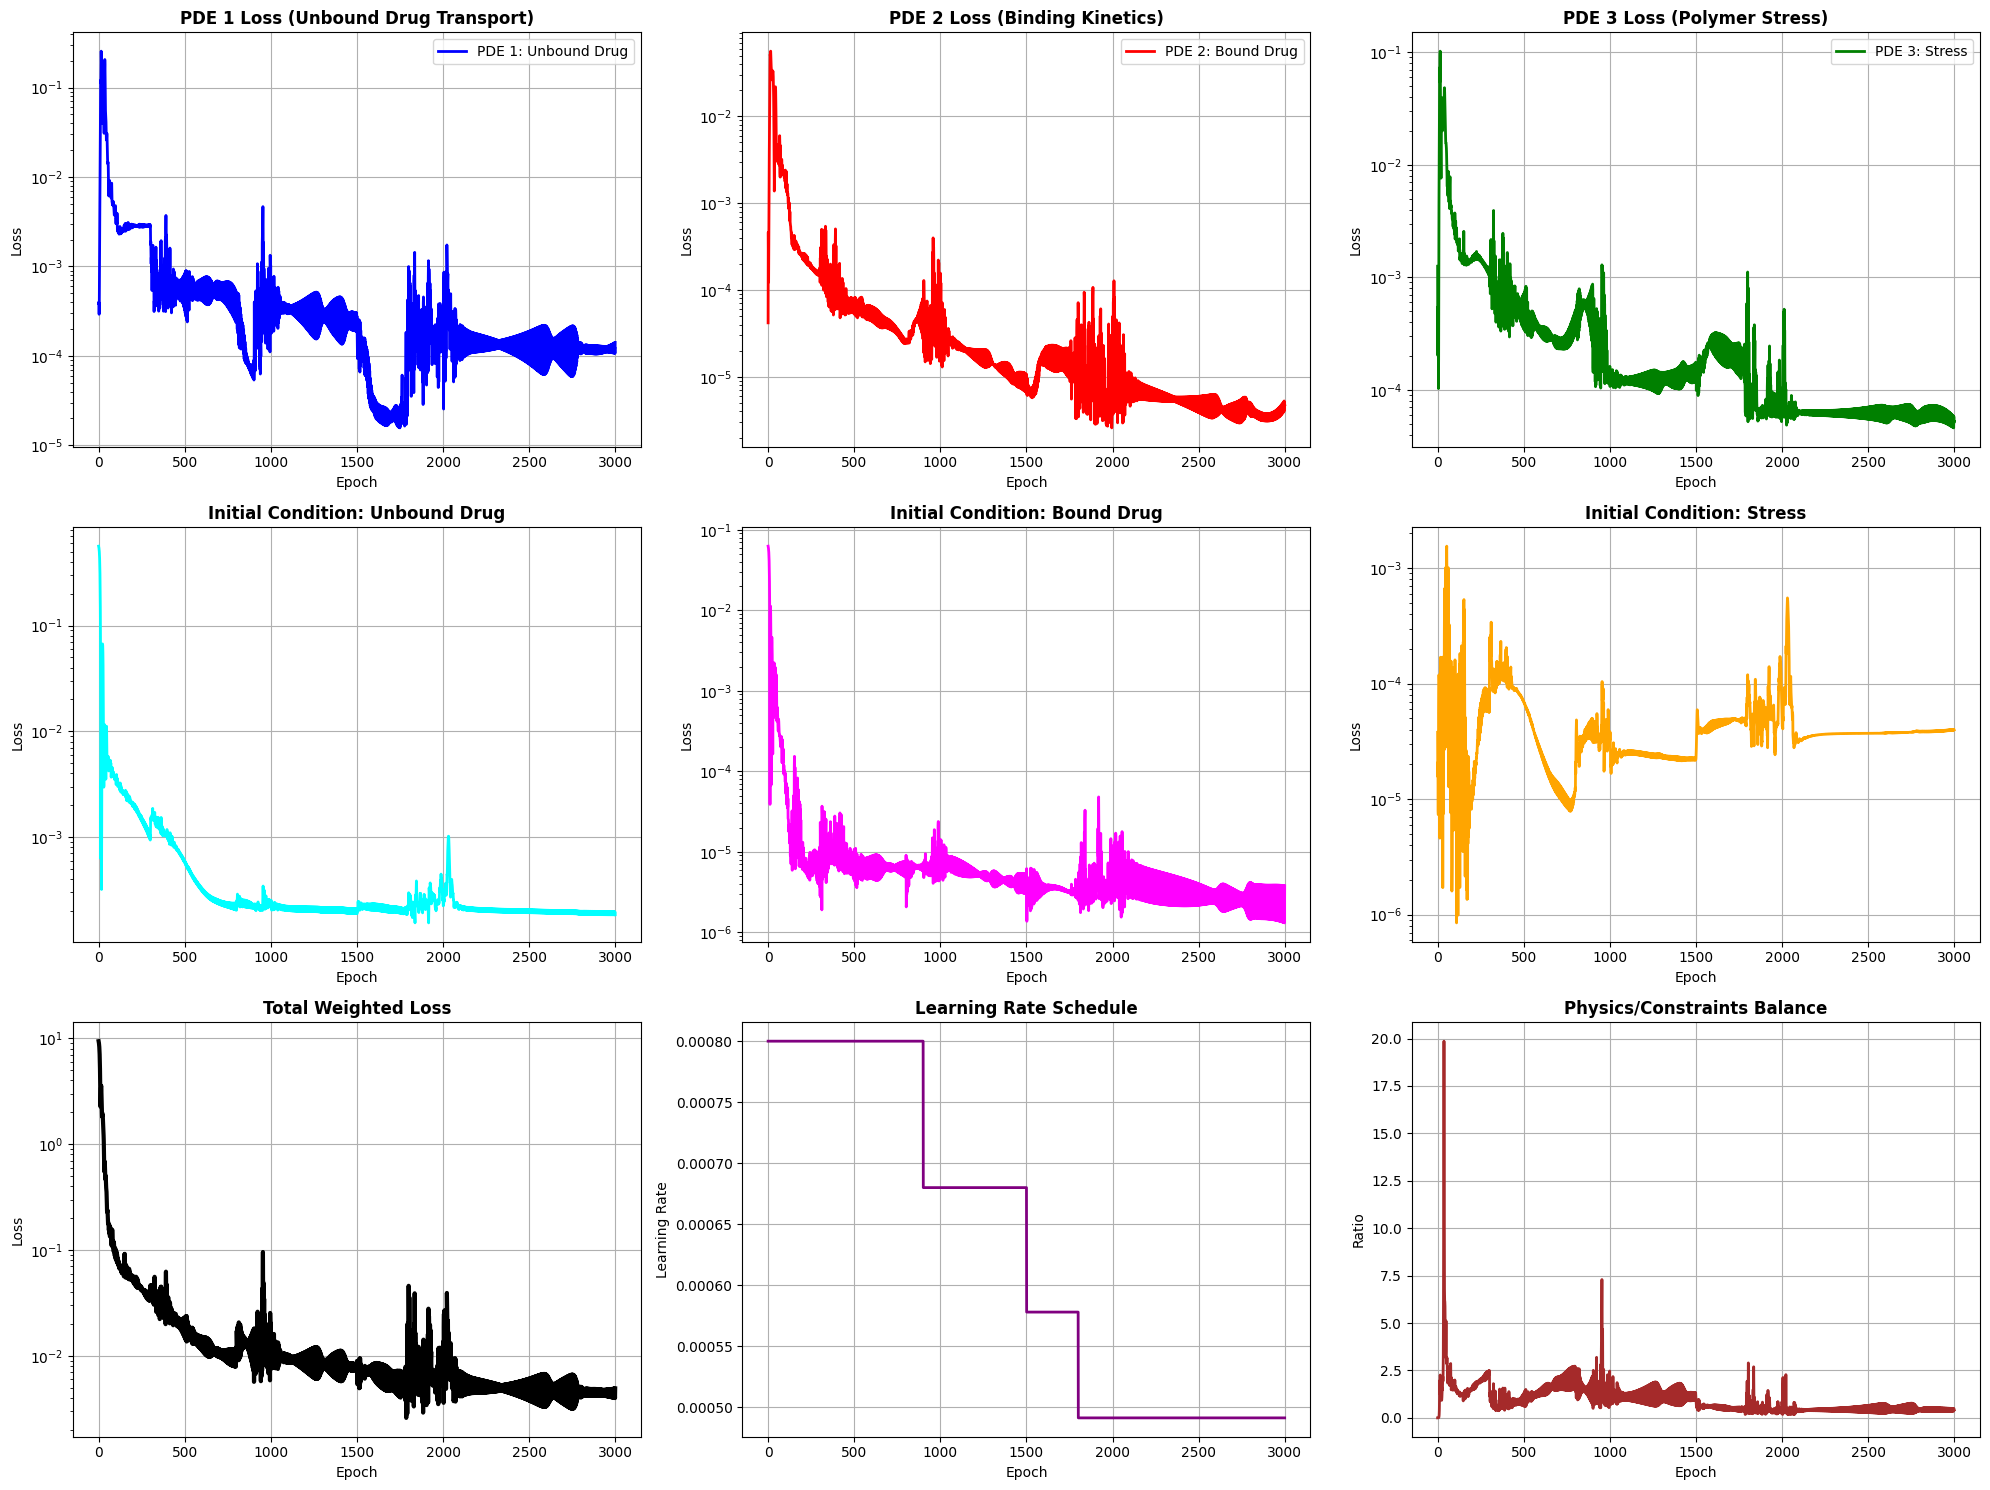

✅ training_progress saved and verified: 770.5 KB
Analyzing 3-PDE compliance across domain...
✅ PDE compliance saved: /content/drive/MyDrive/3PDE_Complete_Results/pde_compliance_20250612_102833.png


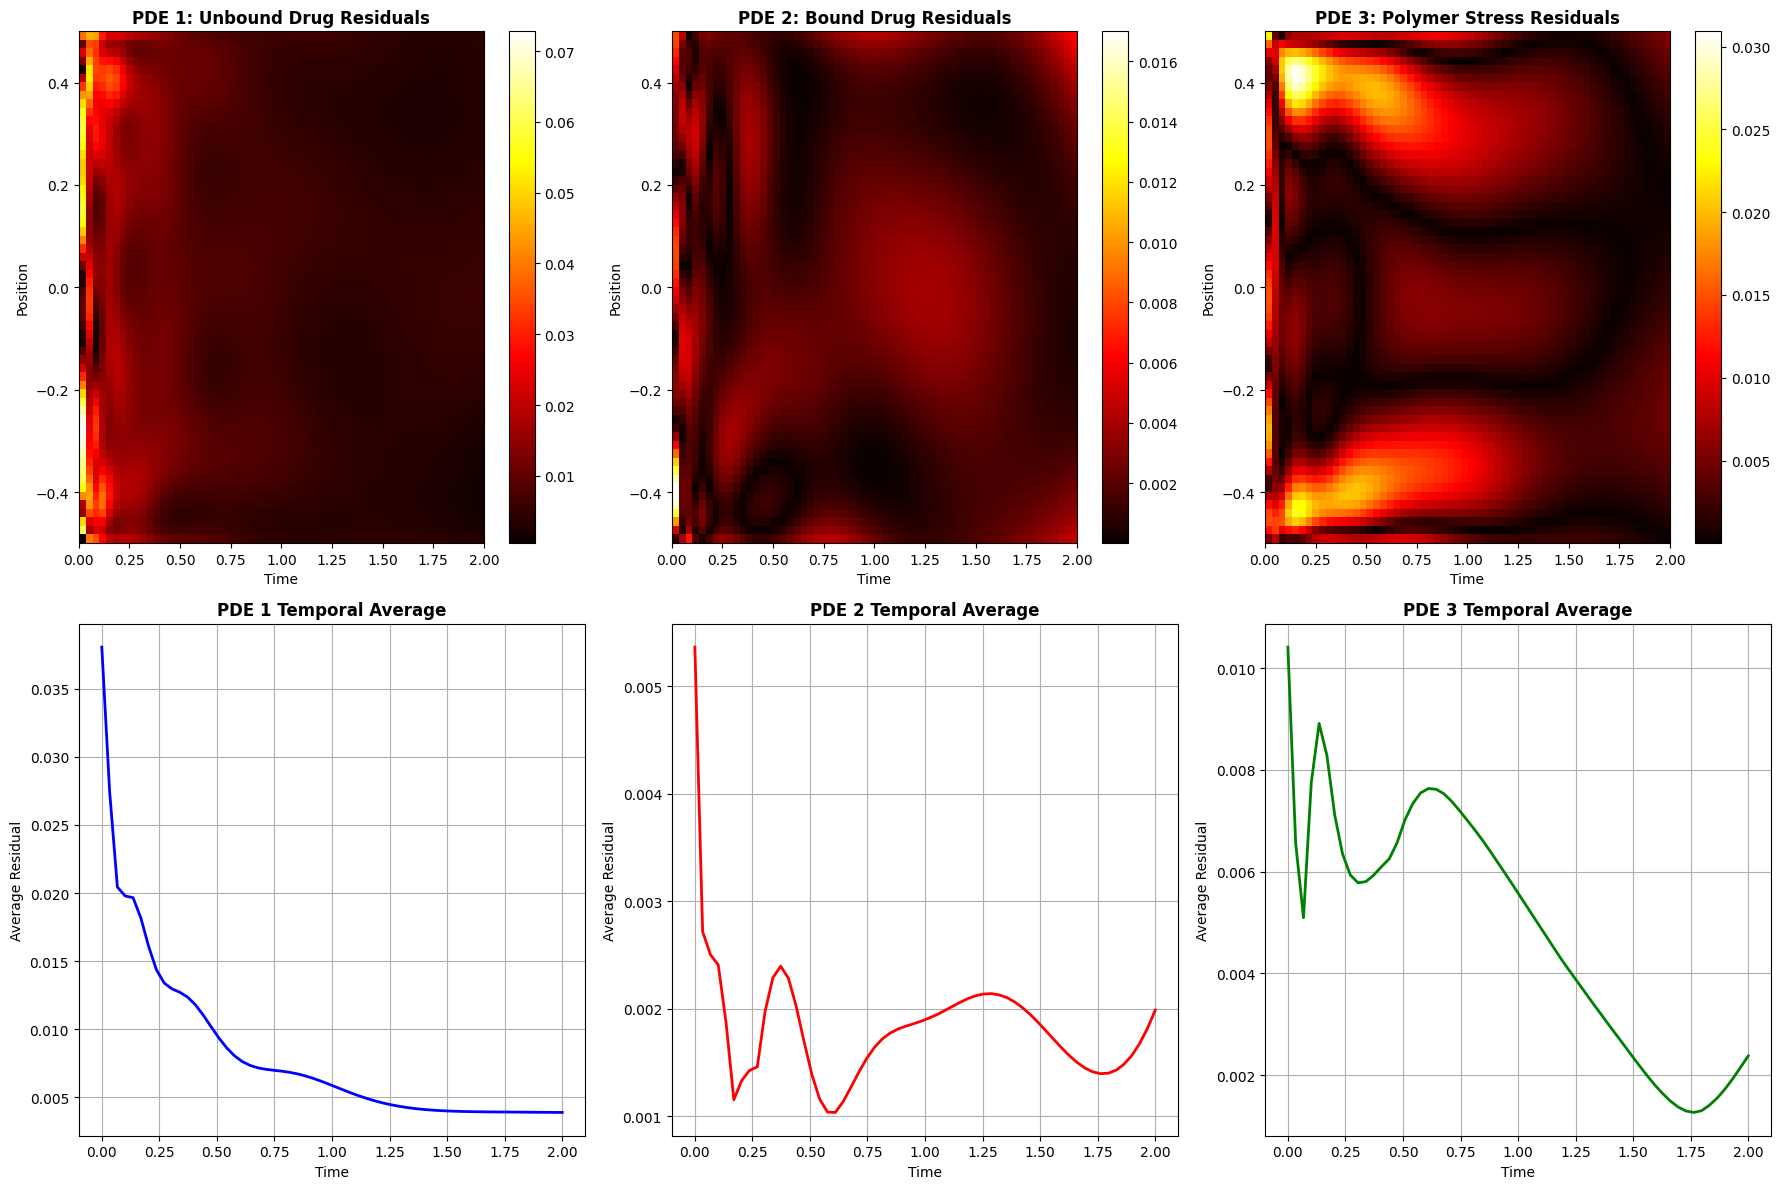


PDE Compliance Statistics:
  PDE 1 (Unbound): Max=0.072802, Mean=0.008245
  PDE 2 (Bound):   Max=0.016994, Mean=0.001830
  PDE 3 (Stress):  Max=0.030922, Mean=0.004842
✅ pde_compliance saved and verified: 472.6 KB
✅ Solution evolution saved: /content/drive/MyDrive/3PDE_Complete_Results/solution_evolution_20250612_102833.png


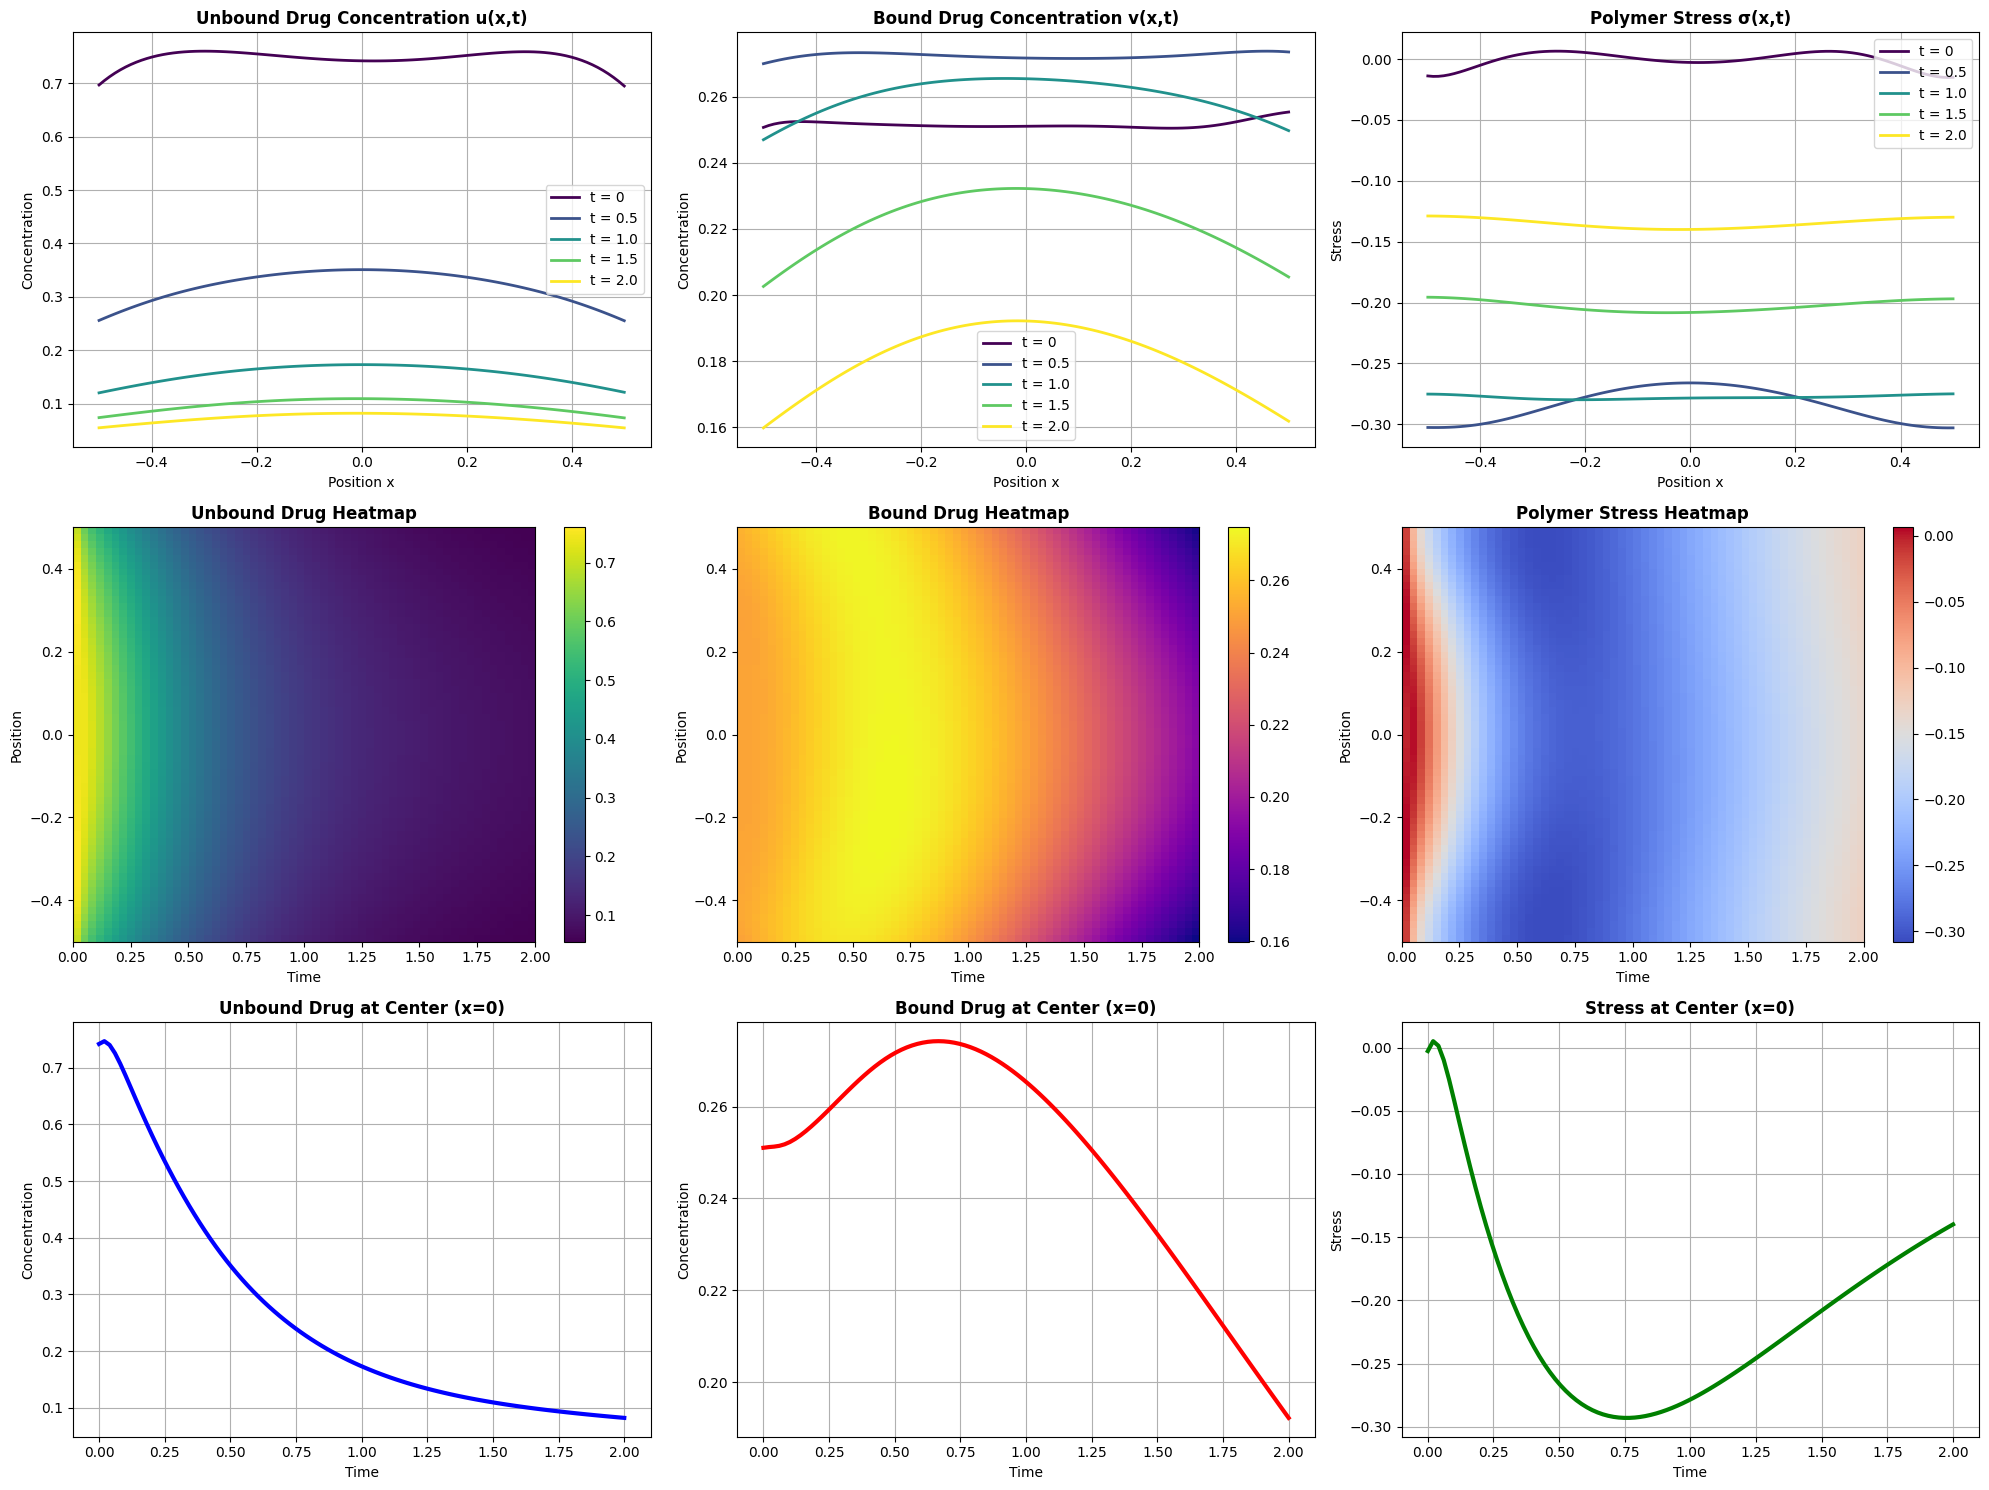

✅ solution_evolution saved and verified: 802.4 KB
📊 Plot saving results: 3/3 successful
4. Running mass conservation analysis...
Analyzing mass conservation and binding dynamics...
  t= 0.0: Unbound=0.7466, Bound=0.2516, Total=0.9982, Stress=0.0051
  t= 0.5: Unbound=0.3207, Bound=0.2724, Total=0.5931, Stress=0.2842
  t= 1.0: Unbound=0.1558, Bound=0.2603, Total=0.4161, Stress=0.2778
  t= 1.5: Unbound=0.0971, Bound=0.2228, Total=0.3198, Stress=0.2027
  t= 2.0: Unbound=0.0725, Bound=0.1813, Total=0.2538, Stress=0.1349

Mass Conservation Analysis:
  t= 0.0: Conservation error = 0.000%
  t= 0.5: Conservation error = 40.585%
  t= 1.0: Conservation error = 58.310%
  t= 1.5: Conservation error = 67.960%
  t= 2.0: Conservation error = 74.578%
✅ Mass conservation analysis completed
5. Saving data files with verification...
✅ JSON logs saved: 834.4 KB
✅ Model saved: 0.5 MB
✅ CSV saved: 313.4 KB
6. Forcing Google Drive sync...
Mounted at /content/drive
✅ Drive sync completed. 9/9 files verified

📋

In [ ]:
# Execute the complete 3-PDE PINN training and analysis
trained_model, loss_data, training_logs = main_execution_BULLETPROOF()
